**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 17: Redundancy Analysis (RDA)

Redundancy analysis (RDA) is used to extract and summarise the variation in a set of response variables (species data in the case of ecology) that can be explained by a set of explanatory variables ('constraints'), such as measurements of environmental properties at the places where the species data were collected from. RDA is a direct gradient analysis approach (up to now we have applied indirect gradient analyses) that highlights linear relationships between components of response variables, i.e. variables that are 'redundant' with (i.e. 'explained' by) a set of predictors. RDA can be thought of as an extension of a multiple linear regression.

Here we use a distance-based Redundancy Analysis (db-RDA) implemented in **vegan**'s `capscale()`. The helpfile states: "Distance-based redundancy analysis (dbRDA) is an ordination method similar to Redundancy Analysis (rda), but it allows non-Euclidean dissimilarity indices, such as Manhattan or Bray–Curtis distance."

## The seaweed dataset
For this example we will use the seaweed data of Smit et al. (2017). Please make sure that you read it! For information about the study, see:

https://github.com/ajsmit/Quantitative_Ecology/blob/main/_GitBook/LaTeX/The_seaweed_data.pdf

I use two data sets. The first, $Y$ (in the file `seaweeds.csv`), comprises distribution records of 847 macroalgal species within each of 58 × 50 km-long sections of the South African coast (updated from Bolton and Stegenga  2002). This represents *ca*. 90% of the known seaweed flora of South Africa, but excludes some very small and/or very rare species for which data are insufficient. The data are from verifiable literature sources and John Bolton and Rob Anderson's own collections, assembled from information collected by teams of phycologists over three decades (Bolton 1986; Stegenga et al. 1997; Bolton and Stegenga 2002; De Clerck et al. 2005). 

The second, $E$ (in `env.csv`), is a dataset of *in situ* coastal seawater temperatures (Smit et al. 2013) derived from daily measurements over up to 40 years.

## Set-up the analysis environment

In [1]:
library(tidyverse)
library(betapart)
library(vegan)
library(gridExtra)
library(grid)
library(gridBase)
library(tidyr)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Load the seaweed data:

In [2]:
spp <- read.csv('/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/SeaweedsSpp.csv')
spp <- dplyr::select(spp, -1)
dim(spp)

[1]  58 847

## Set-up the data

The first step involves the species table ($Y$). First I compute the Sørensen dissimilarity, which I then decompose into ‘nestedness-resultant’ ($\beta_\text{sne}$) and ‘turnover’ ($\beta_\text{sim}$) components using the `betapart.core()` and `betapart.pair()` functions of the **betapart** package (Baselga et al., 2017). These are placed into the matrices $Y1$ and $Y2$. It is not necessary to decompose into $Y1$ and $Y2$, but I do so here because I want to focus on the turnover component without a nestedness-resultant influence. Optionally, I can apply a CA, PCoA, or nMDS on $Y$ to find the major patterns in the community data. The formal analysis will use the species data in a distance-based redundancy analyses (db-RDA as per **vegan**'s `capscale()` function) by coupling it with $E$.

In [3]:
Y.core <- betapart.core(spp) 
Y.pair <- beta.pair(Y.core, index.family = "sor")

# Let Y1 be the turnover component (beta-sim):
Y1 <- as.matrix(Y.pair$beta.sim)

It is now necessary to load the environmental data and some setup files that partition the 58 coastal sections (and the species and environmental data that fall within these sections) into bioregions.

The thermal (environmental) data contain various variables, but in the analysis I use only some of them. These data were obtained from many sites along the South African coast, but using interpolation (not included here) I calculated the thermal properties for each of the coastal sections for which seaweed data are available. Consequently we have a data frame with 58 rows and a column for each of the thermal metrics.

In [4]:
load("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/SeaweedEnv.RData")
dim(env)

[1] 58 18

Note that they have the same number of rows as the seaweed data.

I select only some of the thermal vars; the rest are collinear with some of the ones I import:

In [5]:
E1 <- dplyr::select(env, febMean, febRange, febSD, augMean,
                    augRange, augSD, annMean, annRange, annSD)

Next I calculate *z*-scores:

In [6]:
E1 <- decostand(E1, method = "standardize")

Four bioregions are recognised for South Africa by Bolton and Anderson (2004) (the variable called `bolton`), namely the Benguela Marine Province (BMP; coastal sections **1**–**17**), the Benguela-Agulhas Transition Zone (B-ATZ; **18**–**22**), the Agulhas Marine Province (AMP; **19**–**43**/**44**) and the East Coast Transition Zone (ECTZ; **44**/**45**–**58**). My plotting functions partition the data into the bioregions and colour code the figures accordingly so I can see regional patterns in $\beta$-diversity emerging.

In [7]:
bioreg <- read.csv('/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/bioregions.csv', header = TRUE)
head(bioreg)

,spal.prov,spal.ecoreg,lombard,bolton
,<chr>,<chr>,<chr>,<chr>
1,BMP,NE,NamBR,BMP
2,BMP,NE,NamBR,BMP
3,BMP,NE,NamBR,BMP
4,BMP,NE,NamBR,BMP
5,BMP,NE,NamBR,BMP
6,BMP,NE,NamBR,BMP


Load the geographic coordinates for the coastal sections:

In [8]:
sites <- read.csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/sites.csv")
sites <- sites[, c(2, 1)]
head(sites)
dim(sites)

,Longitude,Latitude
,<dbl>,<dbl>
1,16.72429,-28.98450
2,16.94238,-29.38053
3,17.08194,-29.83253
4,17.25928,-30.26426
5,17.47638,-30.67874
6,17.72167,-31.08580


[1] 58  2

Again, we have 58 rows of data for both the coastal section coordinates and the bioregions. You may omit the dataset with spatial coordinates as it is not actually used further below. Can you think of ways in which to use this dataset to graphically represent the spatial distribution of some environmental or biodiversity data?

## Start the RDA

I test the niche difference mechanism as the primary species compositional assembly process operating along South African shores. I suggest that the thermal gradient along the coast provides a suite of abiotic (thermal) conditions from which species can select based on their physiological tolerances, and hence this will structure $\beta$-diversity. For this mechanism to function one would assume that all species have equal access to all sections along this stretch of coast, thus following 'Beijerinck’s Law' that everything is everywhere but the environment selects (Sauer, 1988).

I do a RDA involving all the thermal variables in $E1$ (the 'global analysis' resulting in the full model, `rda_full`). Analysis shown for $Y1$:

In [9]:
# fit the full model:
rda_full <- capscale(Y1 ~., E1)
rda_full
# summary(rda_full)

Call: capscale(formula = Y1 ~ febMean + febRange + febSD + augMean +
augRange + augSD + annMean + annRange + annSD, data = E1)

               Inertia Proportion Rank
Total          7.52344    1.00000     
Constrained    6.86398    0.91235    8
Unconstrained  1.02840    0.13669   28
Imaginary     -0.36895   -0.04904   24
Inertia is squared Unknown distance 
Some constraints were aliased because they were collinear (redundant)

Eigenvalues for constrained axes:
 CAP1  CAP2  CAP3  CAP4  CAP5  CAP6  CAP7  CAP8 
5.620 1.155 0.074 0.006 0.004 0.003 0.001 0.001 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
0.5768 0.1687 0.1096 0.0413 0.0322 0.0243 0.0179 0.0103 
(Showing 8 of 28 unconstrained eigenvalues)


Is the fit significant? I run a permutation test to check:

In [10]:
anova(rda_full, parallel = 4) # ... yes!

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,8,6.863982,40.8807,0.001
Residual,49,1.028405,NA,NA


Since the fit is significant (the environmental variables capture the variation seen in the species data), I compute the adjusted $R^{2}$:

In [11]:
rda_full_R2 <- RsquareAdj(rda_full)$adj.r.squared
round(rda_full_R2, 2)

[1] 0.9

Inertia accounted for by constraints:

In [12]:
round(sum(rda_full$CCA$eig), 2)

[1] 6.86

Remaining (unconstrained) inertia:

In [13]:
round(sum(rda_full$CA$eig), 2)

[1] 1.03

Total inertia:

In [14]:
round(rda_full$tot.chi, 2)

[1] 7.52

What is the variation explained by the full set environmental variables?

In [15]:
round(sum(rda_full$CCA$eig) / rda_full$tot.chi * 100, 2) # in %

[1] 91.23

I check for collinearity using variance inflation factors (VIF), and retain a subset of non-collinear variables to include in the 'reduced' or 'final' model. A common rule is that values over 10 indicate redundant constraints. I run the VIF procedure iteratively, each time removing the highest VIF and examining the remaining ones until these are mostly below 10.

First on the full model:

In [16]:
vif.cca(rda_full)

febMean   febRange      febSD    augMean   augRange      augSD    annMean 
 91.129700   6.775959   7.734436  73.090382   8.486631  12.118914 233.400746 
  annRange      annSD 
        NA   5.396343

Drop annMean:

In [17]:
E2 <- dplyr::select(E1, -annMean)
rda_sel1 <- capscale(Y1 ~., E2)
vif.cca(rda_sel1)

febMean  febRange     febSD   augMean  augRange     augSD  annRange     annSD 
24.996152  6.149245  7.160637 17.717936  8.066340 10.726117        NA  5.396275

Drop febMean:

In [18]:
E3 <- dplyr::select(E2, -febMean)
rda_sel2 <- capscale(Y1 ~., E3)
vif.cca(rda_sel2)

febRange     febSD   augMean  augRange     augSD  annRange     annSD 
 6.149245  7.160637  1.619233  8.066340 10.726117  5.529971  5.396275

We select E3 as the variables to construct the final model (`rda_final`) from:

In [19]:
rda_final <- rda_sel2

We calculate the significance of the model, the variance explained by all the constraints (in $E3$) in the final model, as well as the $R^{2}$:

In [20]:
# is the fit significant?
anova(rda_final, parallel = 4) # ... yes!

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,7,6.825063,45.67541,0.001
Residual,50,1.067324,NA,NA


Which axes are significant?

In [21]:
anova(rda_final, by = "axis", parallel = 4) # ... yes!

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
CAP1,1,5.617936009,263.17859640,0.001
CAP2,1,1.124244745,52.66652264,0.001
CAP3,1,0.072531264,3.39780950,0.381
CAP4,1,0.004952809,0.23201998,1.000
CAP5,1,0.002720164,0.12742919,1.000
CAP6,1,0.001349479,0.06321786,1.000
CAP7,1,0.001328608,0.06224014,0.999
Residual,50,1.067323879,NA,NA


Extract the significant variables in $E3$ that are influential in the final model as influencers of seaweed community differences amongsth coastal sections:

In [22]:
(rda_final_axis_test <- anova(rda_final, by = "terms", parallel = 4))

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
febRange,1,1.09622899,51.3540925,0.001
febSD,1,0.18497387,8.6653111,0.001
augMean,1,5.38149659,252.1023232,0.001
augRange,1,0.09026584,4.2286060,0.024
augSD,1,0.02117148,0.9918020,0.352
annRange,1,0.01962051,0.9191449,0.378
annSD,1,0.03130580,1.4665559,0.230
Residual,50,1.06732388,NA,NA


The significant variables are:

In [23]:
rda_final_ax <- which(rda_final_axis_test[, 4] < 0.05)
rda_final_sign_ax <- colnames(E3[,rda_final_ax])
rda_final_sign_ax

[1] "febRange" "febSD"    "augMean"  "augRange"

The adjusted $R^{2}$ for the constraints:

In [24]:
round(rda_final_R2 <- RsquareAdj(rda_final)$adj.r.squared, 2) # %

[1] 0.89

Variance explained by reduced (final) model:

In [25]:
round(sum(rda_final$CCA$eig) / rda_final$tot.chi * 100, 2)

[1] 90.72

The biplot scores for constraining variables:

In [26]:
scores(rda_final, display = "bp", choices = c(1:2))

,CAP1,CAP2
febRange,-0.17951109,-0.90202271
febSD,-0.08259676,-0.50969451
augMean,0.98516406,0.15657181
augRange,0.03499429,-0.14728687
augSD,-0.01944793,-0.07441746
annRange,0.41313533,-0.18050396
annSD,0.20412535,-0.56833391


These biplot scores will mark the position of the termini of the arrows that indicate the direction and strength of the constraining variables.

## Ordination diagrams

This code recreates Figure 2a in Smit et al. (2017):

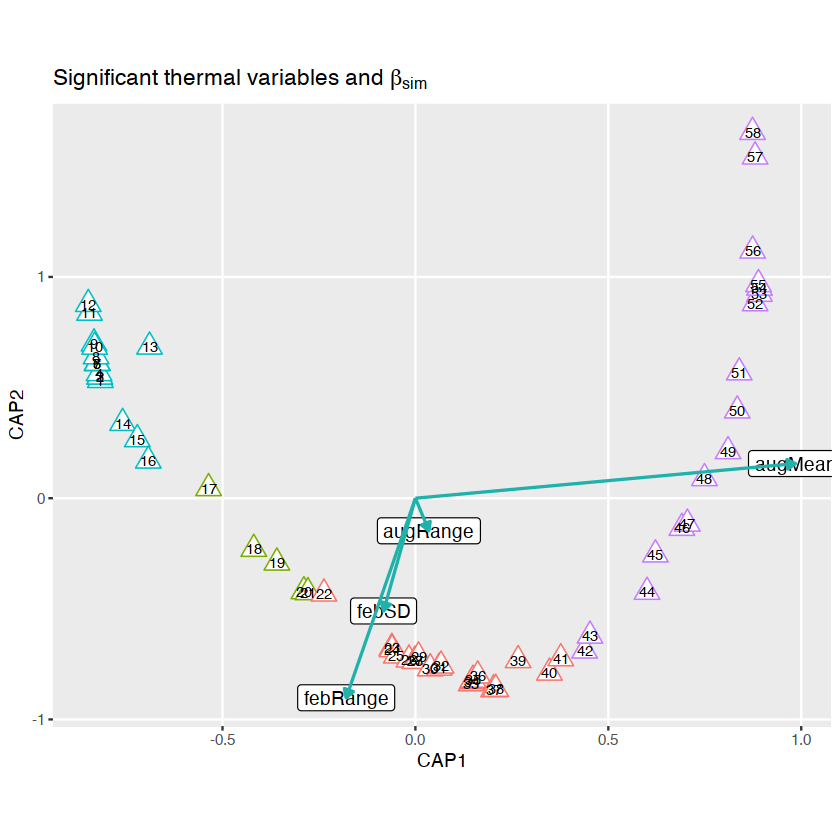

In [27]:
# use scaling = 1 or scaling = 2 for site and species scaling, respectively
rda_final_scrs <- scores(rda_final, display = c("sp", "wa", "lc", "bp"))
# see ?plot.cca for insight into the use of lc vs wa scores
# below I splot the wa (site) scores rather than lc (constraints) scores
site_scores <- data.frame(rda_final_scrs$site) # the wa scores
site_scores$bioreg <- bioreg$bolton
site_scores$section <- seq(1:58)

biplot_scores <- data.frame(rda_final_scrs$biplot)
biplot_scores$labels <- rownames(biplot_scores)
biplot_scores_sign <- biplot_scores[biplot_scores$labels %in% rda_final_sign_ax,]

ggplot(data = site_scores, aes(x = CAP1, y = CAP2, colour = bioreg)) +
  geom_point(size = 5.0, shape = 24, fill = "white") +
  geom_text(aes(label = section), size = 3.0, col = "black") +
  geom_label(data = biplot_scores_sign,
             aes(CAP1, CAP2, label = rownames(biplot_scores_sign)),
             color = "black") +
  geom_segment(data = biplot_scores_sign,
               aes(x = 0, y = 0, xend = CAP1, yend = CAP2),
               arrow = arrow(length = unit(0.2, "cm"), type = "closed"),
               color = "lightseagreen", alpha = 1, size = 0.7) +
  xlab("CAP1") + ylab("CAP2") +
  ggtitle(expression(paste("Significant thermal variables and ", beta[sim]))) +
  theme_grey() +
  theme(panel.grid.minor = element_blank(),
        legend.position = "none",
        aspect.ratio = 0.8)

Note that in Smit et al. (2017, Fig. 2a) I plot the linear constraints (lc scores) rather than the site scores (wa scores). The fact that the positioning of the site scores in ordination space in the figure, above, represents a crude map of South Africa corresponding with geographical coordinates (N-E-S-W) is coincidental (yet it can be logically explained). The coenoclines and gradients are clearly discernible, and the west to east numbering of sites and transitioning of one bioregon into the next are obvious. This map-like arrangement of sites disappears when lc scores are used, but the interpretation of how the thermal drivers structure seaweed biodiversity remains the same.

## Dealing with factor variables

,febRange,febSD,augMean,augRange,augSD,annRange,annSD,bioreg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-0.04433865,-0.2713395,-1.376511,-0.47349787,-0.409770805,-1.0460150,-1.636461,BMP
2,-0.14318268,-0.1083868,-1.433925,-0.06998551,-0.096490845,-0.7657214,-1.307622,BMP
3,-0.39321619,-0.1719978,-1.526950,0.02484832,0.009053095,-0.6311568,-1.143445,BMP
4,-0.60199306,-0.3120605,-1.579735,-0.05076148,0.005487982,-0.5861267,-1.074994,BMP
5,-0.64081940,-0.4095900,-1.546420,-0.09833845,0.041336545,-0.8799034,-1.200028,BMP
6,-0.55083241,-0.4294142,-1.458642,-0.11132528,0.095589389,-1.2225182,-1.343088,BMP


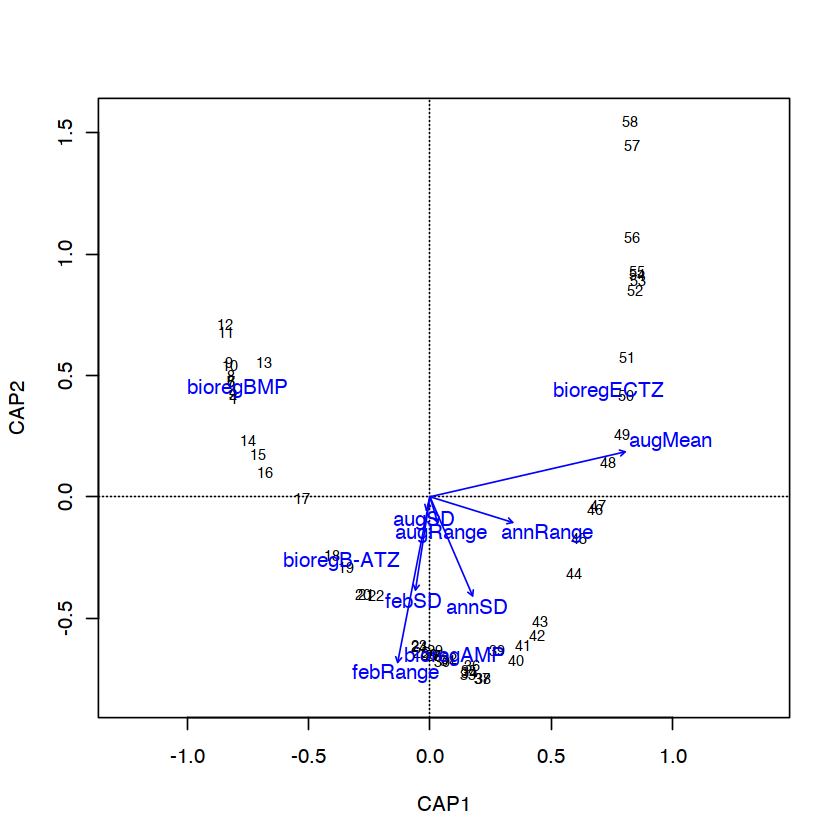

In [28]:
E4 <- E3
# append the bioregs after the thermal vars
E4$bioreg <- bioreg$bolton
head(E4)
rda_cat <- capscale(Y1 ~., E4)
plot(rda_cat)

The default plot works okay and shows all necessary info, but the various pieces (site, species, and centroid scores) are not clearly discernable. Plot the class (factor) centroids in `ggplot()`:

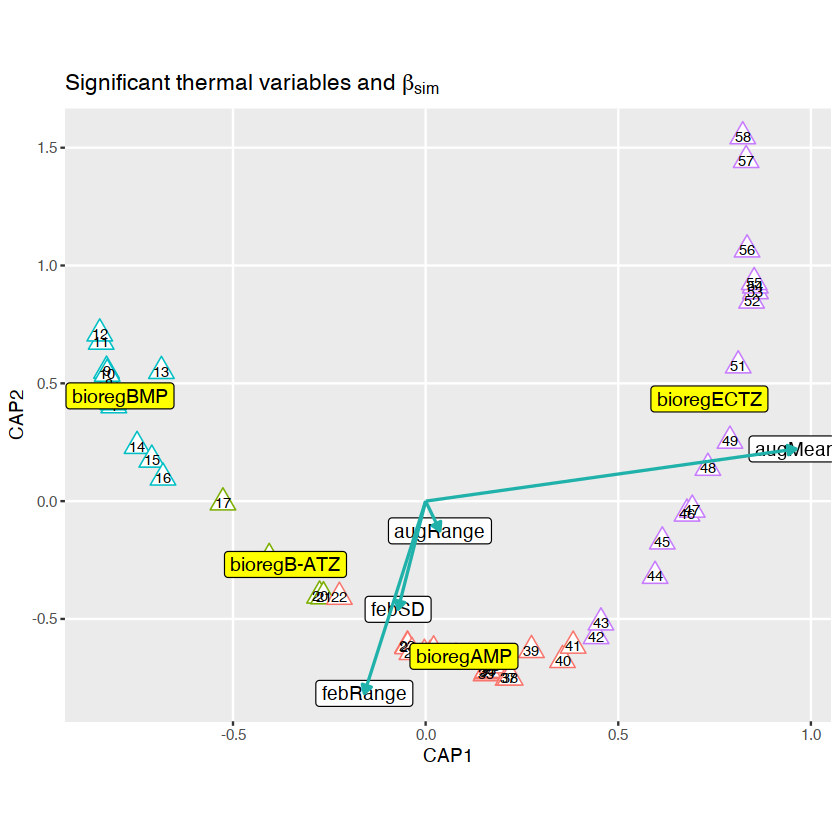

In [29]:
# also extractthe factor centroids for the bioregions
rda_cat_scrs <- scores(rda_cat, display = c("sp", "wa", "lc", "bp", "cn"))
site_scores <- data.frame(rda_cat_scrs$site) # the wa scores
site_scores$bioreg <- bioreg$bolton
site_scores$section <- seq(1:58)

biplot_scores <- data.frame(rda_cat_scrs$biplot)
biplot_scores$labels <- rownames(biplot_scores)
biplot_scores_sign <- biplot_scores[biplot_scores$labels %in% rda_final_sign_ax,]

bioreg_centroids <- data.frame(rda_cat_scrs$centroids)
bioreg_centroids$labels <- rownames(bioreg_centroids)
  
ggplot(data = site_scores, aes(CAP1, CAP2, colour = bioreg)) +
  geom_point(size = 5.0, shape = 24, fill = "white") +
  geom_text(aes(label = section), size = 3.0, col = "black") +
  geom_label(data = biplot_scores_sign,
             aes(CAP1, CAP2, label = rownames(biplot_scores_sign)),
             color = "black") +
  geom_segment(data = biplot_scores_sign,
               aes(x = 0, y = 0, xend = CAP1, yend = CAP2),
               arrow = arrow(length = unit(0.2, "cm"), type = "closed"),
               color = "lightseagreen", alpha = 1, size = 0.7) +
  geom_label(data = bioreg_centroids,
             aes(x = CAP1, y = CAP2,
                 label = labels), size = 4.0,
             col = "black", fill = "yellow") +
  xlab("CAP1") + ylab("CAP2") +
  ggtitle(expression(paste("Significant thermal variables and ", beta[sim]))) +
  theme_grey() +
  theme(panel.grid.minor = element_blank(),
        legend.position = "none",
        aspect.ratio = 0.8)

## References

Baselga, A., Orme, D., Villeger, S., De Bortoli, J., and Leprieur, F. (2017). betapart: Partitioning Beta Diversity into Turnover and Nestedness Components. R package version 1.4-1. Available online at: https://CRAN.R-project.org/package=betapart

Bolton, J. J. (1986). Marine phytogeography of the Benguela upwelling region on the west coast of southern Africa: A temperature dependent approach. Botanica Marina 29, 251–256.

Bolton, J. J., and Anderson, R. J. (2004). “Marine vegetation,” in Vegetation of Southern Africa, eds R. M. Cowling, D. M. Richardson, and S. M. Pierce, (Cambridge, UK: Cambridge University Press), 348–370.

Bolton, J. J., and Stegenga, H. (2002). Seaweed species diversity in South Africa. South African Journal of Marine Science 24, 9–18.

De Clerck, O., Bolton, J. J., Anderson, R. J., and Coppejans, E. (2005). Guide to the seaweeds of KwaZulu- Natal. Scripta Botanica Belgica 33, 294 pp.

Sauer, J. D. (1988). Plant migration: The dynamics of geographic patterning in seed plant species. University of California Press.

Smit, A. J., Bolton, J. J., and Anderson, R. J. (2017). Seaweeds in two oceans: beta-diversity. Frontiers in Marine Science, 4, 404.

Stegenga, H., Bolton, J. J., and Anderson, R. J. (1997). Seaweeds of the South African west coast. Contributions of the Bolus Herbarium 18, 3–637.